In [2]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
%matplotlib inline

## Dataset: Diagnostic Wisconsin Breast Cancer Dataset

__Source:__ https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29

In [3]:
#load/clean/prep data
df = pd.read_csv('breast_cancer_data.csv')

#remove last column of Nans
df = df.drop('Unnamed: 32',1)

#change diagnosis to 0 (benign) or 1 (malignant)
df['diagnosis'] = df['diagnosis'].map(lambda x: 1 if x == 'M' else 0)

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,1,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,1,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,1,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,1,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Feature Selection

In [7]:
#get variables with above .5 correlation
df_temp = pd.DataFrame(df.corr()['diagnosis'])
df_temp = df_temp.loc[df_temp['diagnosis'] >= .5].sort_values(['diagnosis'],
                                                             ascending=False)
df_temp = df_temp.reset_index()
variables = df_temp['index'].tolist()

#dataframe with only selected variables
df2 = df[variables]
df2.head()

,diagnosis,concave points_worst,perimeter_worst,concave points_mean,radius_worst,perimeter_mean,area_worst,radius_mean,area_mean,concavity_mean,concavity_worst,compactness_mean,compactness_worst,radius_se,perimeter_se,area_se
0,1,0.2654,184.60,0.14710,25.38,122.80,2019.0,17.99,1001.0,0.3001,0.7119,0.27760,0.6656,1.0950,8.589,153.40
1,1,0.1860,158.80,0.07017,24.99,132.90,1956.0,20.57,1326.0,0.0869,0.2416,0.07864,0.1866,0.5435,3.398,74.08
2,1,0.2430,152.50,0.12790,23.57,130.00,1709.0,19.69,1203.0,0.1974,0.4504,0.15990,0.4245,0.7456,4.585,94.03
3,1,0.2575,98.87,0.10520,14.91,77.58,567.7,11.42,386.1,0.2414,0.6869,0.28390,0.8663,0.4956,3.445,27.23
4,1,0.1625,152.20,0.10430,22.54,135.10,1575.0,20.29,1297.0,0.1980,0.4000,0.13280,0.2050,0.7572,5.438,94.44


Let's see how just these features do in regressions without further transformation

In [4]:
#create train and test sets
trainsize = int(df2.shape[0] / 2)
df2_test = df2.iloc[trainsize:, :].copy()
df2_train = df2.iloc[:trainsize, :].copy()

## Vanilla Logistic Regression

In [5]:
#train lr model
lr = LogisticRegression(C=1) #C is parameter regularization coefficient
Y_train = df2_train['diagnosis']
X_train = df2_train.loc[:, ~(df2_train.columns).isin(['diagnosis'])]
lr.fit(X_train, Y_train)
print('\nR-squared train:')
print(lr.score(X_train, Y_train))


R-squared train:
0.9507042253521126


In [6]:
#run on test set
Y_test = df2_test['diagnosis']
X_test = df2_test.loc[:, ~(df2_test.columns).isin(['diagnosis'])]
print('\nR-squared test:')
print(lr.score(X_test, Y_test))


R-squared test:
0.9333333333333333


In [26]:
#double check with cross val score
from sklearn.model_selection import cross_val_score
scores_lr = cross_val_score(lr,
                            df2.drop('diagnosis', 1),
                            df2['diagnosis'],
                            cv=10)
print('score array:\n', scores_lr)
print('\nscore array mean:\n', np.mean(scores_lr))
print('\nscore array std dev:\n', np.std(scores_lr))

score array:
 [0.94827586 0.9137931  0.92982456 0.92982456 0.96491228 0.96491228
 0.94736842 0.92857143 0.94642857 0.98214286]

score array mean:
 0.9456053927923257

score array std dev:
 0.019727296848694224


## Ridge Regression

In [22]:
#train ridge model
ridgeregr = linear_model.Ridge(alpha=.0001, fit_intercept=False)
ridgeregr.fit(X_train, Y_train)
print('\nR-squared train:')
print(ridgeregr.score(X_train, Y_train))


R-squared train:
0.7085222099715307


In [45]:
#run model on test
print('\nR-squared test:')
print(ridgeregr.score(X_test, Y_test))


R-squared test:
0.7675093197190834


In [29]:
#double check with cross val score
scores_ridge = cross_val_score(ridgeregr,
                               df2.drop('diagnosis', 1),
                               df2['diagnosis'],
                               cv=10)
print('score array:\n', scores_ridge)
print('\nscore array mean:\n', np.mean(scores_ridge))
print('\nscore array std dev:\n', np.std(scores_ridge))

score array:
 [0.34405513 0.66023341 0.72953762 0.58569931 0.70191585 0.74665225
 0.77029705 0.70137461 0.6400434  0.7175091 ]

score array mean:
 0.659731774450768

score array std dev:
 0.11705766902891122


## Lasso Regression

In [44]:
#train lasso model
lass = linear_model.Lasso(alpha=.02)
lass.fit(X_train, Y_train)
print('\nR-squared train:')
print(lass.score(X_train, Y_train))


R-squared train:
0.6538837608287689


In [46]:
#run lasso on test
print('\nR-squared train:')
print(lass.score(X_test, Y_test))


R-squared train:
0.5239559630961352


In [47]:
#double check with cross val score
scores_lass = cross_val_score(lass,
                              df2.drop('diagnosis', 1),
                              df2['diagnosis'],
                              cv=10)
print('score array:\n', scores_lass)
print('\nscore array mean:\n', np.mean(scores_lass))
print('\nscore array std dev:\n', np.std(scores_lass))

score array:
 [0.02483092 0.59968138 0.63370033 0.6046482  0.71996877 0.65112038
 0.64889648 0.61239154 0.48863427 0.60482033]

score array mean:
 0.5588692604011827

score array std dev:
 0.18628883099947877


## Further feature analysis & transformation

In [11]:
df2.head()
df2.columns

Index(['diagnosis', 'concave points_worst', 'perimeter_worst',
       'concave points_mean', 'radius_worst', 'perimeter_mean', 'area_worst',
       'radius_mean', 'area_mean', 'concavity_mean', 'concavity_worst',
       'compactness_mean', 'compactness_worst', 'radius_se', 'perimeter_se',
       'area_se'],
      dtype='object')

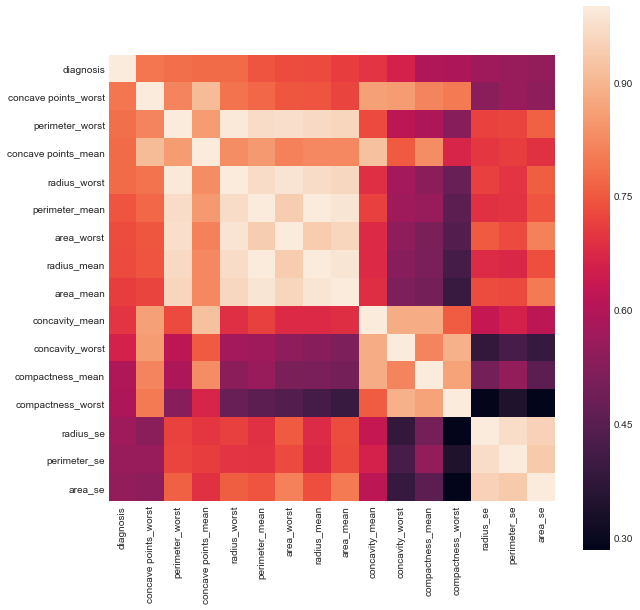

In [35]:
plt.figure(figsize=(10,10))
sns.heatmap(df2.corr(), square=True)
plt.show()

In [58]:
c = df2.corr().abs()
s = c.unstack()
so = pd.DataFrame(s.sort_values(kind='quicksort', ascending=False))
so = so.reset_index()
so.columns = ['var1', 'var2', 'corr']
so = so[so['corr'] < 1]
so.drop_duplicates(subset='corr', keep='first', inplace=True)
so = so[so['corr'] > .5]
so = so[(so.var1 != 'diagnosis') & (so.var2 != 'diagnosis')]
#so.groupby('var1').count()
so

,var1,var2,corr
16,perimeter_mean,radius_mean,0.997855
18,radius_worst,perimeter_worst,0.993708
20,area_mean,radius_mean,0.987357
22,area_mean,perimeter_mean,0.986507
24,radius_worst,area_worst,0.984015
26,area_worst,perimeter_worst,0.977578
28,radius_se,perimeter_se,0.972794
30,perimeter_mean,perimeter_worst,0.970387
32,radius_mean,radius_worst,0.969539
34,perimeter_mean,radius_worst,0.969476
